In [1]:
import pandas as pd
import numpy as np
from keras.utils import np_utils
#Not displaying the warnings on the screen
import warnings
warnings.filterwarnings("ignore")

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


<h3>Step 1 : Reading the data </h3><br>
<h4>Scaling</h4>
Since we are scaling the data. The <b>StandardScaler</b> object of sklearn is going to be used. For this purpose a function <b><i>preprocess_data</i></b> is defined:

In [2]:
from sklearn.preprocessing import StandardScaler
def preprocess_data(X, scaler=None):
    """Preprocess input data by standardising the features 
    This is achieved by removing the mean and scaling to unit variance"""
    if not scaler:
        scaler = StandardScaler()
        scaler.fit(X)
    X = scaler.transform(X)
    return X, scaler

<hr>
<h4>Encoding data </h4><br>
There are 9 classes in the training set. In stead of putting the classes into a column vector with values 1,2,..9. A matrix with 9 columns is produced. A value in column $k$ means that we are dealing with an item belonging to class $k$. <br>
This is handled by the <b>LabelEncoder</b> object of sklearn

In [3]:
from sklearn.preprocessing import LabelEncoder
def preprocess_labels(labels):
    """Encode labels with values among 0 and `n-classes-1`"""
    encoder = LabelEncoder()
    encoder.fit(labels)
    y = encoder.transform(labels).astype(np.int32)
    y = np_utils.to_categorical(y)
    return y, encoder

In [4]:
df_train= pd.read_csv('data/train.csv')
Y_train = df_train.values[:,-1] # last column
X_train = df_train.values[:,1:-1] #skip the first column (=id) and the last (the model-class)

The outcome of Y_Train has the following classes 

In [5]:
np.unique(Y_train)

array(['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6',
       'Class_7', 'Class_8', 'Class_9'], dtype=object)

Scaling the data with the standard scaler object

In [6]:
X_train,scaler = preprocess_data(X_train)

Encoding the class labels into N x 9 matrix

In [7]:
Y_train,encoder = preprocess_labels(Y_train)

Inspect the data

In [8]:
dims = X_train.shape
print('dimensions input:', dims[0],'(observations) x',dims[1],'(features)')

dimensions input: 61878 (observations) x 93 (features)


In [9]:
nb_classes = Y_train.shape[1]
print('Nbr of classes:',nb_classes)

Nbr of classes: 9


In [10]:
pd.DataFrame(Y_train[0:5,:]).head()

,0,1,2,3,4,5,6,7,8
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<h3> Step 2: Keras </h3><br>
<h4>Building network </h4>
Creating a neural network with one inputlayer, one hidden layer. 

In [11]:
from keras.models import Sequential
from keras.layers import Dense, Activation


In [12]:
model = Sequential()
model.add(Dense(nb_classes, input_shape=(dims[1],), activation='sigmoid'))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 9)                 846       
_________________________________________________________________
activation_1 (Activation)    (None, 9)                 0         
Total params: 846
Trainable params: 846
Non-trainable params: 0
_________________________________________________________________


<h4>Compile network</h4>

In [13]:
model.compile(optimizer='sgd', loss='categorical_crossentropy')

<h4>Fit data to network</h4>
This fires off the backpropagation ....

In [14]:
model.fit(X_train, Y_train)

Epoch 1/1
61878/61878 [==============================] - 3s 47us/step - loss: 1.9916


<h4>Predict the class or the model </h4>
We calculate the traing error by applying the predicct_classes method on the training set. Only the first result is shown. It shows the column number in the Y_train matrix.

In [26]:

print('Predicted class = Nr',model.predict_classes(X_train)[0],'(not the class name)')

Predicted class = Nr 5 (not the class name)


In [16]:
print('Predicted probabilities',model.predict(X_train)[0,:])

Predicted probabilities [0.1635501  0.09338133 0.10442213 0.08138411 0.09570205 0.18278402
 0.08436777 0.08497865 0.10942981]


The total sum of predicted probabilites is equal to 1. This comes frm the property of the softmax function.
<br><hr>

In [17]:
sum(model.predict(X_train)[0,:])

0.999999962747097

<h3> Step 3: Make a prediction </h3><br>

Creating a neural network with one inputlayer, one hidden layer. 

Reading the testdata from the test.csv file

In [18]:
df_test= pd.read_csv('data/test.csv')
print('Nbr of samples in test:',df_test.shape[0])
X_test = df_test.values[:,1:]

Nbr of samples in test: 144368


The test data has to be processed by the scaler we obtained when processing the training data:

In [19]:
X_test_scaled = scaler.transform(X_test)

Using the test data and making a prediction using the network <br>

In [20]:
Y_test = model.predict_classes(X_test_scaled)
Y_test_prob = model.predict(X_test_scaled)

In [21]:
print(Y_test[0])
print(Y_test_prob[0,:])

2
[0.07863063 0.15812896 0.17550245 0.134862   0.0765084  0.06841233
 0.13467436 0.07938789 0.09389295]


Using the inverse_transform function of the encoder object to retrieve the class names. Display the result for the first 5 items

In [22]:
encoder.inverse_transform(Y_test[0:5])

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array(['Class_3', 'Class_6', 'Class_6', 'Class_2', 'Class_9'],
      dtype=object)

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

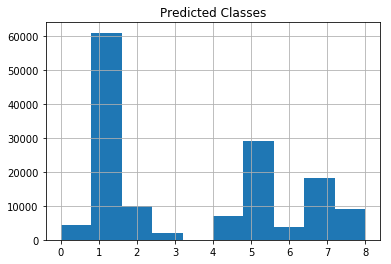

In [24]:
pd.DataFrame(Y_test,columns=['Predicted Classes']).hist();